In [ ]:
# to do

# add comments under results from log rank test
# add comments under cox proportional hazards model

# label x and y axis in all plots

# combine some of the plots and put them on the same subplot

# add more EDA 

In [81]:
# general packages
import pandas as pd
import numpy as np

# specialized stats packages
from lifelines import KaplanMeierFitter

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# preferences
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Data

I will use one of default datasets from lifetimes library. I don't know much about it and would prefer to avoid jumping to conclusions so I will pretend this data comes actually from a survey among 26 vampires collected a 100 years ago. 

In [2]:
# data
from lifelines.datasets import load_psychiatric_patients

df = load_psychiatric_patients()

In [126]:
df.head()


,Age,T,C,sex
0,51,1,1,2
1,58,1,1,2
2,55,2,1,2
3,28,22,1,2
4,21,30,0,1


In [148]:
df.describe()

,Age,T,C,sex
count,26.000000,26.000000,26.000000,26.000000
mean,35.153846,26.423077,0.538462,1.576923
std,10.479284,11.559146,0.508391,0.503831
min,19.000000,1.000000,0.000000,1.000000
25%,28.250000,22.500000,0.000000,1.000000
50%,32.500000,30.500000,1.000000,2.000000
75%,42.500000,34.750000,1.000000,2.000000
max,58.000000,40.000000,1.000000,2.000000


# Plotting lifetimes

In [70]:
# the function below is a modified version of plotting function from the lifetimes library. All credit should go to
# them and all faults are mine.

def plot_lifetimes(lifetimes, event_observed=None, birthtimes=None,
                   order=False, block=True):
    """
    Parameters:
      lifetimes: an (n,) numpy array of lifetimes.
      event_observed: an (n,) numpy array of booleans: True if event observed, else False.
      birthtimes: an (n,) numpy array offsetting the births away from t=0.
    Creates a lifetime plot, see
    examples:
    """
    from matplotlib import pyplot as plt

    N = lifetimes.shape[0]
    if N > 100:
        print("warning: you may want to subsample to less than 100 individuals.")

    if event_observed is None:
        event_observed = np.ones(N, dtype=bool)

    if birthtimes is None:
        birthtimes = np.zeros(N)

    if order:
        """order by length of lifetimes; probably not very informative."""
        ix = np.argsort(lifetimes, 0)
        lifetimes = lifetimes[ix, 0]
        event_observed = event_observed[ix, 0]
        birthtimes = birthtimes[ix]
    
    fig, ax = plt.subplots(figsize=[15,5], frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for i in range(N):
        c = "#663366" if event_observed[i] else "green"
        l = 'burned by the sun rays or an angry mob' if event_observed[i] else "alive"
        
        plt.hlines(N - 1 - i, birthtimes[i], birthtimes[i] + lifetimes[i], color=c, lw=3, label=l if (i == 0) or (i==40)  else "")
        m = "|" if not event_observed[i] else 'o'
        plt.scatter((birthtimes[i]) + lifetimes[i], N - 1 - i, color=c, s=30, marker=m)
        plt.legend(fontsize=16)

    plt.xlabel("Number of years since becoming a vampire", size=18)
    plt.ylabel("Individual vampires", size=20)
    plt.vlines(current_time, 0, N, lw=2, linestyles='--', alpha=0.5)
    plt.xticks(fontsize=18)
    plt.ylim(-0.5, N)
    return

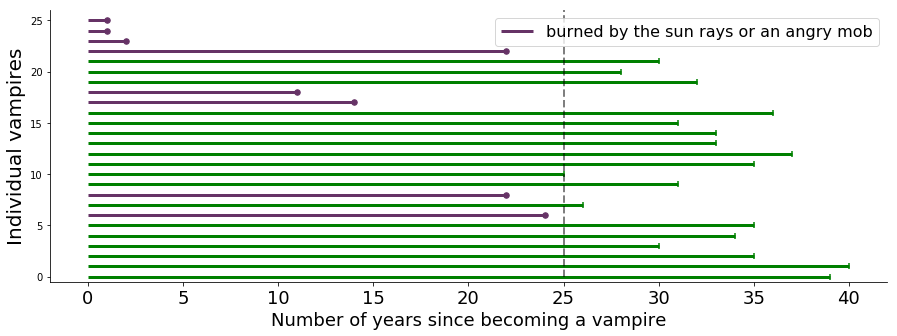

In [71]:
current_time = 25
actual_lifetimes = df['T'].values
observed_lifetimes = actual_lifetimes
observed = actual_lifetimes < current_time

plot_lifetimes(observed_lifetimes, event_observed=observed, block=True)

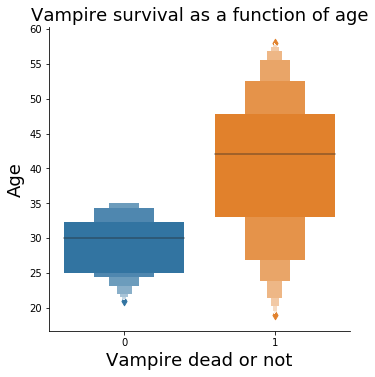

In [147]:

sns.catplot(x="C", y="Age", kind="boxen",
            data=df.sort_values("C"));
plt.xlabel('Vampire dead or not', size=18)
plt.ylabel('Age', size=18)
plt.title('Vampire survival as a function of age', size=18);


# Kaplan-Meier curve

In [6]:
kmf = KaplanMeierFitter()
T = df["T"] #duration
C = df["C"] 

In [7]:
kmf.fit(T,C);

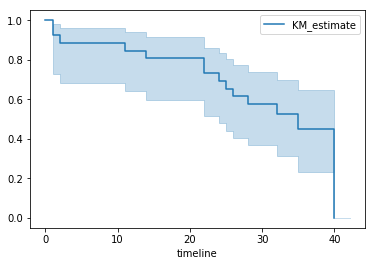

In [8]:
kmf.survival_function_
kmf.median_
kmf.plot()

## Kaplan-Meier curve plotted separately for vampires who define themselves as men or women

Unfortunately gender in this dataset is binary, even though in overall vampires are very supportive of their queer community.

<Figure size 720x720 with 0 Axes>

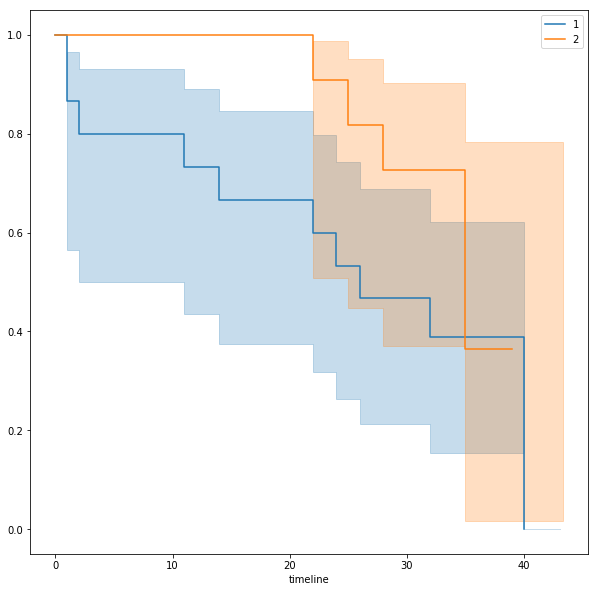

In [89]:
# plot both genders on the same plot
plt.figure(figsize=[10,10])

groups = df['sex']
ix = (groups == 1)

kmf.fit(T[~ix], C[~ix], label='1')
ax = kmf.plot(figsize=[10,10])

kmf.fit(T[ix], C[ix], label='2')
kmf.plot(ax=ax)

# Hazard rate using Nelson-Aalen estimator

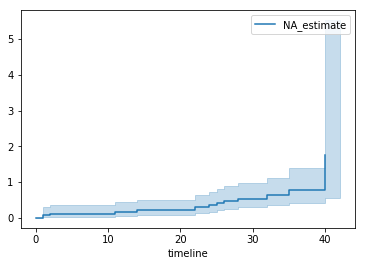

In [22]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(T,event_observed=C);
naf.plot()

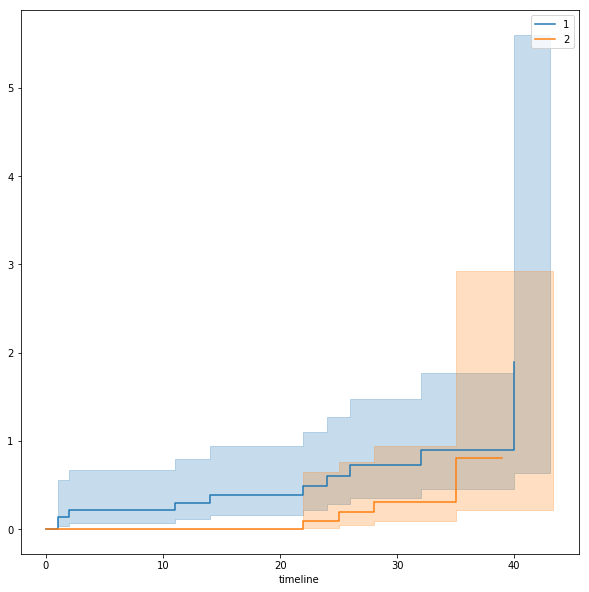

In [90]:
naf.fit(T[~ix], C[~ix], label='1')
ax = naf.plot(figsize=[10,10])

naf.fit(T[ix], C[ix], label='2')
naf.plot(ax=ax)

# Statistical analysis of differences

## Is there a difference between survival rate for two groups? Log rank test

In [12]:
 from lifelines.statistics import logrank_test

 results = logrank_test(T[ix], T[~ix], event_observed_A=C[ix], event_observed_B=C[~ix])
 results.print_summary()

Results
   t 0: -1
   test: logrank
   alpha: 0.95
   null distribution: chi squared
   df: 1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.20485 |              1.607 |  Cannot Reject Null |       False       


In [97]:
Z = results.test_statistic
D = C.count()

log_lambda = Z * np.sqrt (D / 4)
log_lambda

4.098143897765532

## What factors influence vampire's survival? Cox Proportional Hazards Model

In [14]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(df, duration_col='T', event_col='C', show_progress=True)

cph.print_summary()  

Convergence completed after 5 iterations.
n=26, number of events=14

       coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
Age  0.2075     1.2306    0.0583  3.5606 0.0004      0.0933      0.3218  ***
sex -0.5237     0.5923    0.7375 -0.7101 0.4776     -1.9696      0.9221     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.816


In [129]:
cph.predict_log_hazard_relative_to_mean([23,15,0,1])

AttributeError: 'list' object has no attribute 'shape'

In [138]:
cph.predict_cumulative_hazard(df)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
event_at,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1.0,0.207440,0.886713,0.475775,0.001754,0.000693,0.000457,0.000941,0.111304,0.090445,0.000941,...,0.004484,0.043962,0.039434,0.059721,0.007497,0.003644,0.012657,0.006791,0.009225,0.006791
2.0,0.436442,1.865590,1.001002,0.003690,0.001457,0.000962,0.001980,0.234177,0.190291,0.001980,...,0.009434,0.092494,0.082968,0.125650,0.015772,0.007666,0.026629,0.014288,0.019410,0.014288
11.0,0.918781,3.927368,2.107270,0.007768,0.003068,0.002026,0.004168,0.492981,0.400593,0.004168,...,0.019861,0.194715,0.174661,0.264514,0.033203,0.016139,0.056058,0.030078,0.040861,0.030078
14.0,1.569538,6.709059,3.599816,0.013269,0.005241,0.003461,0.007120,0.842152,0.684326,0.007120,...,0.033928,0.332628,0.298370,0.451865,0.056720,0.027570,0.095763,0.051382,0.069802,0.051382
22.0,3.386619,14.476253,7.767385,0.028631,0.011309,0.007467,0.015362,1.817126,1.476583,0.015362,...,0.073207,0.717718,0.643798,0.974998,0.122386,0.059488,0.206629,0.110869,0.150612,0.110869
24.0,4.522616,19.332121,10.372852,0.038235,0.015102,0.009972,0.020516,2.426657,1.971884,0.020516,...,0.097764,0.958467,0.859751,1.302048,0.163439,0.079442,0.275940,0.148058,0.201133,0.148058
25.0,6.210701,26.547915,14.244561,0.052507,0.020739,0.013694,0.028173,3.332417,2.707897,0.028173,...,0.134255,1.316219,1.180657,1.788043,0.224443,0.109094,0.378936,0.203322,0.276207,0.203322
26.0,8.143806,34.811058,18.678237,0.068850,0.027194,0.017956,0.036942,4.369644,3.550741,0.036942,...,0.176042,1.725897,1.548141,2.344578,0.294302,0.143051,0.496881,0.266607,0.362177,0.266607


In [135]:
pd.DataFrame(np.array([1,2,3,1]))

,0
0,1
1,2
2,3
3,1


In [136]:
x =np.array([23,45,0,1])

In [ ]:
np.array()